# PARABOLA

In [1]:
%matplotlib inline
import matplotlib
import os
import itertools
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from SensorimotorExploration.DataManager.SimulationData import load_sim_h5_v2 as load_sim_h5
from SensorimotorExploration.DataManager.PlotTools import *

In [3]:
def create_dict(groups_k):
    return {k[0] + '_' + k[1]: [] for k in groups_k}

def incremental_mean(arr_):
    n_samples = len(arr_)
    sum_ = 0
    out = []
    for i in range(n_samples):
        sum_ += arr_[i]
        out += [sum_/(i + 1.)]
    out = np.array(out).flatten()
    return out

def moving_av(arr_, win_sz):
    n_samples = len(arr_)
    sum_ = 0
    out = []
    for i in range(win_sz):
        sum_ += arr_[i]
        out += [sum_/(i + 1.)]
    for i in range(win_sz,n_samples):
        sum_ = sum_ + arr_[i] - arr_[i-win_sz]
        out += [sum_/win_sz]
    out = np.array(out).flatten()
    return out

def std_markers(ax,y,m,c,sz):
    pass
    """
    plt.sca(ax)
    plt.hold(True)
    for i,(y_,ms_) in enumerate(zip(y,sz)):
        plt.plot(i, y_, marker = m, ms = ms_, color = c)
    """

In [17]:
directory = 'parabola_slope_social_thresh_4/'
data_files = os.listdir(directory)

n_samples = 10200

# Group by:
mode_ops = ['autonomous','social']
alpha_social_thresh = ['1', '0_99', '0_98', '0_87', '0_96', '0_95']

groups_k = list(itertools.product(alpha_social_thresh,mode_ops))

#container for error evolution
means_e = create_dict(groups_k)
means_av_e = create_dict(groups_k)

#container for social error evolution
means_s = create_dict(groups_k)
means_av_s = create_dict(groups_k)

#container for whole evaluation error evolution
means_w = create_dict(groups_k)
means_av_w = create_dict(groups_k)

#container for acomulated collisions
coll_e = create_dict(groups_k)
coll_av_e = create_dict(groups_k)

#container for collisions in social evaluation (not used)
coll_s = create_dict(groups_k)
coll_av_s = create_dict(groups_k)

#container for collisions in whole evaluation (not used)
coll_w = create_dict(groups_k)
coll_av_w = create_dict(groups_k)

#container for interactions data 
inter = create_dict(groups_k)
inter_av = create_dict(groups_k)

#container for errors
error_ev = create_dict(groups_k)
error_ev_av = create_dict(groups_k)

#container for standar deviations
std_ev = create_dict(groups_k)

#container for competence during exploration
comp_w = create_dict(groups_k)
comp_av_w = create_dict(groups_k)


for data_file in (d_f for d_f in data_files if 'sim_data.h5' in d_f):
    data_file = directory + data_file
    conf_file = data_file.replace('sim_data.h5', 'conf.txt')
    conf = {}
    with open(conf_file) as f:
        for line in f:
            line = line.replace('\n', '')
            (key, val) = line.split(': ')
            conf[key] = val

    try:
        data,foo = load_sim_h5(data_file)
        interaction_data = data.social.data.as_matrix(columns=None)
        interactions = np.zeros((n_samples,))
        interactions[~np.isnan(interaction_data[:n_samples, 0])] = 1

        social_data, foo = load_sim_h5(data_file.replace('sim_data.h5', 'eval_social_sensor_eva_valset.h5'))
        whole_data, foo = load_sim_h5(data_file.replace('sim_data.h5', 'eval_whole_sensor_eva_valset.h5'))

        s_error_ = np.linalg.norm(social_data.sensor_goal.data.as_matrix() -
                                  social_data.sensor.data.as_matrix(), axis=1)
        
        s_con_v = social_data.cons.data.as_matrix()
    
        
        wh_error_ = np.linalg.norm(whole_data.sensor.data.as_matrix() -
                                  whole_data.sensor.data.as_matrix(), axis=1)

        wh_con_v = data.cons.data.as_matrix()

        e_con_v = data.cons.data.as_matrix()
        
        
        
        error_ = np.linalg.norm(data.sensor_goal.data.as_matrix() -
                                          data.sensor.data.as_matrix(), axis=1)

        error_ss_ = np.linalg.norm(data.somato_goal.data.as_matrix() -
                                  data.somato.data.as_matrix(), axis=1)


        eva_errors = []
        with open(data_file.replace('sim_data.h5', 'eval_error.txt'), 'r') as f:
            for line in f:
                line.replace('\n', '')
                eva_errors_str = line.split(': ')
                eva_errors += [float(eva_errors_str[1])]

        conf['instructor_slope'] = conf['instructor_slope'].replace('.','_')
        means_s[conf['instructor_slope'] + '_' + conf['mode']] += [np.mean(s_error_)]
        means_w[conf['instructor_slope'] + '_' + conf['mode']] += [np.mean(wh_error_)]

        
        coll_s[conf['instructor_slope'] + '_' + conf['mode']] += [s_con_v]
        coll_w[conf['instructor_slope'] + '_' + conf['mode']] += [wh_con_v[:n_samples]]
        coll_e[conf['instructor_slope'] + '_' + conf['mode']] += [e_con_v[:n_samples]]
        
        inter[conf['instructor_slope'] + '_' + conf['mode']] += [interactions]

        error_ev[conf['instructor_slope'] + '_' + conf['mode']] += [eva_errors]

        comp_w[conf['instructor_slope'] + '_' + conf['mode']] += [error_[:n_samples]]
        #wh_comp_w[conf['instructor_slope'] + '_' + conf['mode']] += [error_ss_[:2200]]  
        
    except IOError:
        print("Something went wrong!")

legend = []
max_std = 0
for i, k in enumerate(groups_k):
    print(k)
    group = k[0] + '_' + k[1] 
    legend += [group]

    means_av_s[group] = np.mean(np.array(means_s[group]))
    means_av_w[group] = np.mean(np.array(means_w[group]))

    
    coll_av_s[group] = np.mean(np.array(coll_s[group]), axis=0)
    coll_av_w[group] = np.mean(np.array(coll_w[group]), axis=0)
    coll_av_e[group] = np.mean(np.array(coll_e[group]), axis=0)

    
    inter_av[group] = np.mean(np.array(inter[group]), axis=0)
    
    comp_av_w[group] = np.mean(np.array(comp_w[group]), axis=0)
    #wh_comp_av_w[group] = np.mean(np.array(wh_comp_w[group]), axis=0)
    
    error_ev_av[group] = np.mean(np.array(error_ev[group]), axis=0)
    std_ev[group] = np.std(np.array(error_ev[group]),axis=0)
    max_std = max(max_std,max(std_ev[group].flatten()))
    
    
print(max_std)

('1', 'autonomous')
('1', 'social')
('0_99', 'autonomous')
('0_99', 'social')
('0_98', 'autonomous')
('0_98', 'social')
('0_87', 'autonomous')
('0_87', 'social')
('0_96', 'autonomous')
('0_96', 'social')
('0_95', 'autonomous')
('0_95', 'social')
0.110013769558


/usr/lib/python2.7/dist-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Average evaluation error
0_95_social: 0.0882432365915
key: 0_95_social, error: 0.0882432365915
0_98_autonomous: 0.114103785034
key: 0_98_autonomous, error: 0.114103785034
0_99_social: 0.0941559748301
key: 0_99_social, error: 0.0941559748301
0_95_autonomous: 0.0817352505823
key: 0_95_autonomous, error: 0.0817352505823
0_87_autonomous: 0.115614539072
key: 0_87_autonomous, error: 0.115614539072
0_96_autonomous: 0.0734222671502
key: 0_96_autonomous, error: 0.0734222671502
0_99_autonomous: 0.111636706197
key: 0_99_autonomous, error: 0.111636706197
1_autonomous: 0.0968192129419
key: 1_autonomous, error: 0.0968192129419
1_social: 0.0894250149337
key: 1_social, error: 0.0894250149337
0_98_social: 0.0685500633365
key: 0_98_social, error: 0.0685500633365
0_96_social: 0.0916585675631
key: 0_96_social, error: 0.0916585675631
0_87_social: 0.0717954516312
key: 0_87_social, error: 0.0717954516312
Error evolution
0_95_social: 0.155514218692
0_98_autonomous: 0.161446711969
0_99_social: 0.124480904385
0

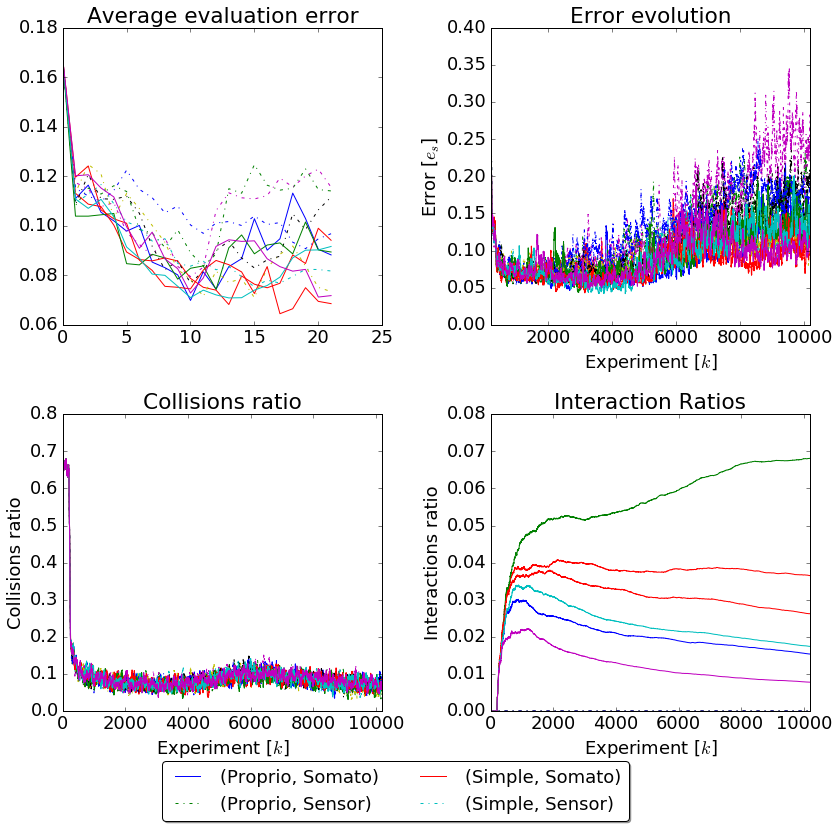

In [19]:
matplotlib.rcParams['figure.figsize'] = (12.0, 11.0)
matplotlib.rcParams.update({'font.size': 18})


fig1, ax1 = plt.subplots(2,2)
plt.sca(ax1[0,0])
plt.gca().set_color_cycle(None)
ax1[0,0].set_title('Average evaluation error')
print('Average evaluation error')
plt.hold(True)
for key in error_ev_av.keys():
    data_plt = error_ev_av[key]
    print("{}: {}".format(key, data_plt[-1]))
    if 'autonomous' in key:
        plt.plot(data_plt, linestyle='-.', marker='')#, color='b')    
    else:
        plt.plot(data_plt, linestyle='-', marker='')#, color='b')
    print("key: {}, error: {}".format(key, error_ev_av[key][-1]))
ms1 = [(x/max_std)*13 + 1 for x in std_ev[key]]
    #plt.legend(error_ev_av.keys())

"""
plt.plot(error_ev_av['proprio_autonomous_sensor'], linestyle='-', marker='', color='r')
ms2 = [(x/max_std)*13 + 1 for x in std_ev['proprio_autonomous_sensor']]

#plt.plot(error_ev_av['simple_autonomous_somato '], linestyle='-', marker='', color='g')
#ms3 = [(x/max_std)*13 + 1 for x in std_ev['simple_autonomous_somato ']]

plt.plot(error_ev_av['simple_autonomous_sensor'], linestyle='-', marker='', color='k')
ms4 = [(x/max_std)*13 + 1 for x in std_ev['simple_autonomous_sensor']]

std_markers(ax1[0,0],error_ev_av['proprio_autonomous_somato '],'o','b',ms1)
std_markers(ax1[0,0],error_ev_av['proprio_autonomous_sensor'],'o','r',ms2)
#std_markers(ax1[0,0],error_ev_av['simple_autonomous_somato '],'o','g',ms3)
std_markers(ax1[0,0],error_ev_av['simple_autonomous_sensor'],'o','k',ms4)

plt.xlabel('Evaluation step [$k_{eval}$]')
plt.ylabel('Mean evaluation error')
# plt.legend(['(Proprio, Social)', '(Proprio, Auto)', '(Simple, Social)', '(Simple, Auto)'],\
#            ncol=2,loc='lower right', fontsize=13)
ax1[0,0].set_xlim([0,10])
ax1[0,0].set_ylim([0,0.25])
"""

plt.sca(ax1[0,1])
ax1[0,1].set_title('Error evolution')
print('Error evolution')
win_sz=50
plt.hold(True)
plt.gca().set_color_cycle(None)
for key in error_ev_av.keys():
    data_plt = moving_av(comp_av_w[key],win_sz)
    print("{}: {}".format(key, data_plt[-1]))
    if 'autonomous' in key:
        plt.plot(data_plt, linestyle='-.', marker='')
    else:
        plt.plot(data_plt, linestyle='-', marker='')
plt.xlabel('Experiment [$k$]')
plt.ylabel('Error [$e_s$]')
# plt.legend(['(Proprio, Social)', '(Proprio, Auto)', '(Simple, Social)', '(Simple, Auto)'],\
#            ncol=2,loc='lower right', fontsize=13)
ax1[0,1].set_xlim([200,n_samples])
ax1[0,1].set_ylim([0,0.4])


plt.sca(ax1[1,0])
ax1[1,0].set_title('Collisions ratio')
print('Collisions ratio')
plt.hold(True)
plt.gca().set_color_cycle(None)
for key in error_ev_av.keys():
    data_plt = moving_av(coll_av_w[key],win_sz)
    print("{}: {}".format(key, data_plt[-1]))
    if 'autonomous' in key:
        plt.plot(data_plt, linestyle='-.', marker='')
    else:
        plt.plot(data_plt, linestyle='-', marker='')

plt.xlabel('Experiment [$k$]')
plt.ylabel('Collisions ratio')
lgd = plt.legend(['(Proprio, Somato)', '(Proprio, Sensor)', '(Simple, Somato)', '(Simple, Sensor)'],\
           ncol=2,loc='lower right', fontsize=18, bbox_to_anchor=(1.8, -0.4),
          fancybox=True, shadow=True)
ax1[1,0].set_xlim([0,n_samples])
ax1[1,0].set_ylim([0,0.8])

plt.sca(ax1[1,1])
ax1[1,1].set_title('Interaction Ratios')
print('Interaction Ratios')
plt.hold(True)
plt.gca().set_color_cycle(None)
for key in error_ev_av.keys():
    data_plt = incremental_mean(inter_av[key])
    print("{}: {}".format(key, data_plt[-1]))
    if 'autonomous' in key:
        plt.plot(data_plt, linestyle='-.', marker='')
    else:
        plt.plot(data_plt, linestyle='-', marker='')
plt.xlabel('Experiment [$k$]')
plt.ylabel('Interactions ratio')
ax1[1,1].set_xlim([0,n_samples])
ax1[1,1].set_ylim([0,0.08])

"""
#plt.plot(moving_av(ss_comp_av_w['proprio_autonomous_somato '],win_sz), linestyle='-', marker='', color='b')
# plt.plot(moving_av(comp_av_w['proprio_autonomous_sensor '],win_sz), linestyle='-', marker='', color='r')
plt.hold(True)
#plt.plot(moving_av(ss_comp_av_w['simple_autonomous_somato '],win_sz), linestyle='-', marker='', color='g')
# plt.plot(moving_av(comp_av_w['simple_autonomous_sensor '],win_sz), linestyle='-', marker='', color='k')
plt.xlabel('Experiment [$k$]')
plt.ylabel('Error [$e_s$]')
# plt.legend(['(Proprio, Social)', '(Proprio, Auto)', '(Simple, Social)', '(Simple, Auto)'],\
#            ncol=2,loc='lower right', fontsize=13)
ax1[1,1].set_xlim([200,2200])
ax1[1,1].set_ylim([0,1])

# plt.sca(ax1[1,1])
# ax1[1,1].set_title('Interactions ratio')
# plt.plot(incremental_mean(inter_av['proprio_autonomous_somato']), linestyle='-', marker='', color='b')
# plt.hold(True)
# plt.plot(incremental_mean(inter_av['simple_autonomous_somato']), linestyle='-', marker='', color='g')
# plt.xlabel('Experiment [$k$]')
# plt.ylabel('Interactions ratio')
# plt.legend(['(Proprio, Social)', '(Simple, Social)'],\
#            ncol=1,loc='lower right', fontsize=13.)
# ax1[1,1].set_xlim([0,2200])
# ax1[1,1].set_ylim([0,0.08])
"""

plt.tight_layout()

In [10]:
means_av_s
# fig1.savefig('/home/yumilceh/Dropbox/Aplicaciones/ShareLaTeX/Epirob 2017/images/parabola_results.eps',\
#              format='eps', dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')

{'0_87_autonomous': 0.0,
 '0_87_social': 0.0,
 '0_95_autonomous': 0.0,
 '0_95_social': 0.0,
 '0_96_autonomous': 0.0,
 '0_96_social': 0.0,
 '0_98_autonomous': 0.0,
 '0_98_social': 0.0,
 '0_99_autonomous': 0.0,
 '0_99_social': 0.0,
 '1_autonomous': 0.0,
 '1_social': 0.0}

In [ ]:
# art = []
# lgd = pylab.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=2)
# art.append(lgd)
# pylab.savefig(
#     "/tmp/foo-fixed.png", additional_artists=art,
#     bbox_inches="tight")

fig1, ax1 = plt.subplots(1,1)
plt.sca(ax1)
ax1.set_title('Average evaluation error during exploration')
plt.errorbar(range(12),error_ev_av['proprio_autonomous_somato'],0.*std_ev['proprio_autonomous_somato'],linestyle='-', marker='o', color='b')
plt.hold(True)
plt.errorbar(range(12),error_ev_av['proprio_autonomous_sensor'],0.*std_ev['proprio_autonomous_sensor'], linestyle='-', marker='o', color='r')
plt.errorbar(range(12),error_ev_av['simple_autonomous_somato'],std_ev['simple_autonomous_somato'], linestyle='-', marker='o', color='g')
plt.errorbar(range(12),error_ev_av['simple_autonomous_sensor'],0.*std_ev['simple_autonomous_sensor'], linestyle='-', marker='o', color='k')
plt.xlabel('Evaluation step [k]')
plt.ylabel('Average evaluation error')
plt.legend(['(Proprio, Social)', '(Proprio, Auto)', '(Simple, Social)', '(Simple, Auto)'],\
           ncol=2,loc='lower right', fontsize=15)
ax1.set_ylim([0,0.5])

In [10]:
inter_av

{'0_87_autonomous': nan,
 '0_87_social': nan,
 '0_95_autonomous': nan,
 '0_95_social': nan,
 '0_96_autonomous': nan,
 '0_96_social': nan,
 '0_98_autonomous': nan,
 '0_98_social': nan,
 '0_99_autonomous': nan,
 '0_99_social': nan,
 '1_autonomous': nan,
 '1_social': nan}